In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from datetime import datetime
from torchvision import datasets, models, transforms
from sklearn import metrics

In [48]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].to_numpy()
        image = torch.tensor(row[1:], dtype=torch.float32)
        label = torch.tensor(row[0], dtype=torch.long)       

        return image, label 


In [45]:
data_train = CSVDataset('mnist_train.csv')
data_test = CSVDataset('mnist_test.csv')

In [46]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = data_train,
    batch_size = batch_size,
    shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = data_test,
    batch_size = batch_size,
    shuffle = False)

In [38]:
def make_layers(cfg, in_channels = 3):
    layers = []
    for v in cfg:
        layers += [nn.Linear(in_channels, v), nn.ReLU()]
        in_channels = v
    return nn.Sequential(*layers)

In [28]:
class ModeloSkLearn(nn.Module):
    def __init__(self,entrada=4,camadas_escondidas=256 ,saida=3):
        super().__init__()
        self.hidden_layers_num = camadas_escondidas
        self.dense_hidden = make_layers(self.hidden_layers_num, entrada)
        self.fc = nn.Linear(self.hidden_layers_num[-1], saida)

    def forward(self, x):
        x = self.dense_hidden(x)
        x = self.fc(x)
        return x

In [29]:
def meu_batch_fit(modelo, funcao_objetivo, otimizador, train_loader, epocas = 10):
    custos = []
    losses = np.zeros(epocas)
    for i in range(epocas):
      train_loss = []
      for x, y in train_loader:
        # zerar os gradientes
        otimizador.zero_grad()

        # reshape the input
        x = x.view(-1,784)

        # forward pass
        y_predito = modelo(x)
        custo = funcao_objetivo(y_predito, y)

        # backward pass
        custo.backward()
        otimizador.step()

        train_loss.append( custo.item() )
      losses[i] = np.mean(train_loss)
      print(f'Epoch {i+1}/{epocas}, Train loss: {losses[i]:.4}')

    return losses

In [30]:
def meu_batch_predict(modelo, test_loader):
    preds = np.array([])
    true_label = np.array([])
    with torch.no_grad():
        for x, y in test_loader:
            # reshape the input
            x = x.view(-1,784)
            outputs = modelo(x)
            # get prediction
            _, y_predito = torch.max(outputs, 1)
            preds = np.concatenate( (preds, y_predito.cpu().numpy()) )
            true_label = np.concatenate( (true_label, y.cpu().numpy()) )
    return preds, true_label

In [47]:
modelo3 = ModeloSkLearn(entrada=784, camadas_escondidas=[256, 128, 64, 32] , saida=10 )
# Funções de otimização e de custo
otimizador = torch.optim.Adam(modelo3.parameters(), lr=0.01)
funcao_objetivo = nn.CrossEntropyLoss()

# treinar o modelo
train_loss = meu_batch_fit(modelo3, funcao_objetivo, otimizador, train_loader, epocas = 2)

Epoch 1/2, Train loss: 0.5264
Epoch 2/2, Train loss: 0.2686


In [49]:
def matriz_confusao(y_test, y_pred, labels):
  matriz = metrics.confusion_matrix(y_test, y_pred)
  tot = np.sum(matriz, axis=1, keepdims=True)
  np.set_printoptions(precision=2)
  m_porc = matriz/tot
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=labels)
  disp.plot(values_format='.2f')
  plt.show()

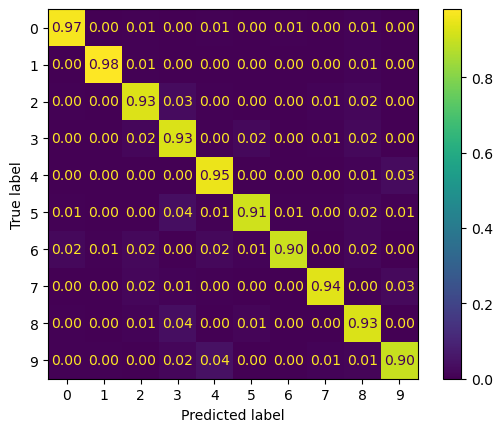

In [50]:
# avaliar o modelo
y_pred, Y_test = meu_batch_predict(modelo3, test_loader)

# gerar matriz de confusão
matriz_confusao(Y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9])

In [56]:
class CSVDataset2D(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].to_numpy()
        image = torch.tensor(row[1:].reshape((1,28,28)), dtype=torch.float32)
        label = torch.tensor(row[0], dtype=torch.long)       

        return image, label 

In [57]:
data_train = CSVDataset2D('mnist_train.csv')
data_test = CSVDataset2D('mnist_test.csv')

In [58]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = data_train,
    batch_size = batch_size,
    shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = data_test,
    batch_size = batch_size,
    shuffle = False)

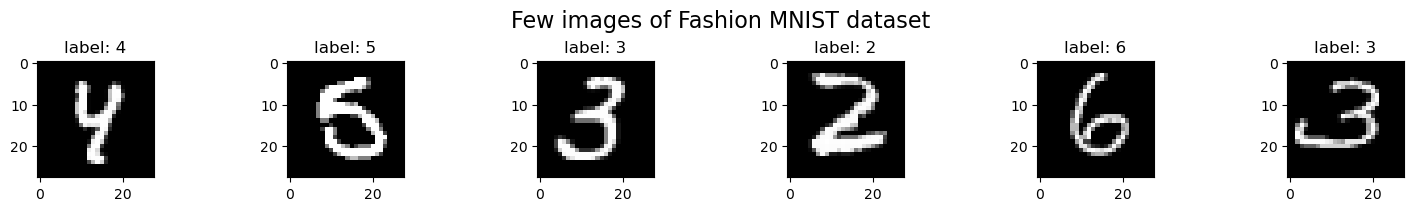

In [59]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 6
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of Fashion MNIST dataset", fontsize=16)
for x, y in train_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:], cmap = 'gray')
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

In [62]:
class Lenet(nn.Module):
    def __init__(self, numChannels, classes):
        # chamar o construtor da classe Base (Pai)
        super(Lenet, self).__init__()

        # definição das camadas convolucionais
        self.conv_layers = nn.Sequential(
            # primeiro grupo convolucional
            nn.Conv2d(in_channels = numChannels, out_channels=20, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # segundo grupo convolucional
            nn.Conv2d(in_channels = 20, out_channels=50, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),            
        )
        # definiçao das camadas fully connected
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=800, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=classes)
        )
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        #out = nn.Flatten(out, start_dim = 1)
        out = self.dense_layers(out)
        return out

In [63]:
def fit(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
 
            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

In [64]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

In [65]:
def predict_module(model, test_loader):
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

In [68]:
# Instanciar a rede
model = Lenet(numChannels=1, classes=10)
device = torch.device("cpu")
model.to(device)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.to(device)
# Loss para varias classes
criterion = nn.CrossEntropyLoss()
# Optimizer
#optimizer = torch.optim.Adagrad( model.parameters() )
optimizer = torch.optim.SGD(model.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

Epoch 1/10 Train Loss: 1.4624 Test Loss: 0.23646528471874284 Duracao: 0:00:25.867327
Epoch 2/10 Train Loss: 0.1510 Test Loss: 0.1084541437743656 Duracao: 0:00:23.973091
Epoch 3/10 Train Loss: 0.0930 Test Loss: 0.07708704472030219 Duracao: 0:00:22.232644
Epoch 4/10 Train Loss: 0.0710 Test Loss: 0.07361688654681173 Duracao: 0:00:22.931725
Epoch 5/10 Train Loss: 0.0599 Test Loss: 0.06427677245398017 Duracao: 0:00:23.221009
Epoch 6/10 Train Loss: 0.0525 Test Loss: 0.060142558566117776 Duracao: 0:00:26.803066
Epoch 7/10 Train Loss: 0.0447 Test Loss: 0.05795596340668235 Duracao: 0:00:25.542923
Epoch 8/10 Train Loss: 0.0399 Test Loss: 0.049610410262336896 Duracao: 0:00:25.625241
Epoch 9/10 Train Loss: 0.0357 Test Loss: 0.05979714987658059 Duracao: 0:00:28.597534
Epoch 10/10 Train Loss: 0.0318 Test Loss: 0.052116504997454134 Duracao: 0:00:28.305327


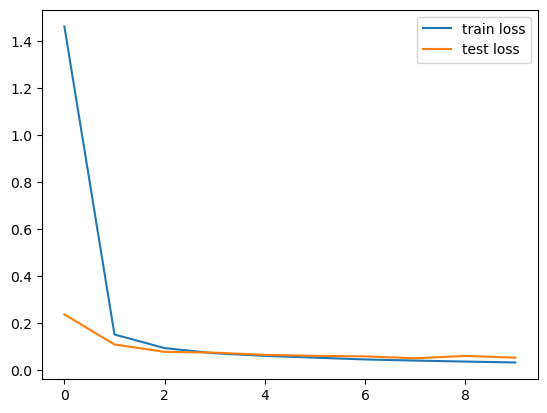

In [69]:

# treino da rede
train_losses, test_losses = fit(model, criterion, optimizer, train_loader, test_loader, epochs = 10)
plot_losses(train_losses, test_losses)